In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import torch
from torch import nn
import tqdm
from einops import rearrange, repeat
import numpy as np
import pytorch_lightning
from pytorch_lightning.utilities import move_data_to_device
import matplotlib.pyplot as plt
import seaborn as sns

from case_studies.dc2_mdt.utils.reverse_markov_learning import RMLDiffusion
from case_studies.dc2_mdt.utils.resample import SigmoidSampler
from case_studies.dc2_mdt.utils.new_simulate_image import ImageSimulator

In [3]:
image_size = 8
max_objects = 2
image_normalize_strategy = "linear_scale"

## RML

In [4]:
class FourierMLP(nn.Module):
    def __init__(self, data_shape, num_layers, hidden_ch):
        super().__init__()
        self.data_shape = [data_shape]

        self.register_buffer(
            "timestep_coeff", torch.linspace(start=0.1, end=100, steps=hidden_ch)[None]
        )  # (1, hidden)
        self.timestep_phase = nn.Parameter(torch.randn(hidden_ch)[None])  # (1, hidden)
        self.input_embed = nn.Sequential(
            nn.Linear(int(np.prod(data_shape)), hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.timestep_embed = nn.Sequential(
            nn.Linear(2 * hidden_ch, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch),
        )
        self.image_embed = nn.Sequential(
            nn.Linear(image_size * image_size, hidden_ch),
            nn.GELU(),
            nn.Linear(hidden_ch, hidden_ch)
        )
        self.layers = nn.Sequential(
            nn.Linear(hidden_ch * 2 + int(np.prod(data_shape)), hidden_ch), 
            nn.GELU(),
            *[
                nn.Sequential(nn.Linear(hidden_ch, hidden_ch), nn.GELU())
                for _ in range(num_layers)
            ],
            nn.Linear(hidden_ch, int(np.prod(data_shape))),
        )

        self.vmap_timestep_embed = torch.vmap(self.timestep_embed.forward, in_dims=1, out_dims=1, randomness="same")
        self.vmap_input_embed = torch.vmap(self.input_embed.forward, in_dims=1, out_dims=1, randomness="same")
        self.vmap_layers = torch.vmap(self.layers.forward, in_dims=1, out_dims=1, randomness="same")

    def forward(self, x, t, image, epsilon, is_training):
        if is_training:
            t = t.unsqueeze(-1)  # (b, m, 1)
            sin_embed_t = torch.sin(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            cos_embed_t = torch.cos(
                (self.timestep_coeff.unsqueeze(0) * t.float()) + self.timestep_phase.unsqueeze(0)
            )
            embed_t = self.vmap_timestep_embed(
                rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                          "d b m w -> b m (d w)")
            )  # (b, m, hidden)
            embed_xt = self.vmap_input_embed(x.flatten(2))  # (b, m, hidden)
            embed_image = self.image_embed(image.flatten(1))  # (b, hidden)
            embed_image = repeat(embed_image, "b hidden -> b m hidden", m=t.shape[1])
            out = self.vmap_layers(
                torch.cat([embed_xt + embed_t, embed_image, epsilon.flatten(2)], dim=-1)
            )
            return out.view(x.shape)
        t = t.clone()
        image = image.clone()
        t = t.unsqueeze(-1)  # (b, 1)
        sin_embed_t = torch.sin(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )  # (b, hidden)
        cos_embed_t = torch.cos(
            (self.timestep_coeff * t.float()) + self.timestep_phase
        )
        embed_t = self.timestep_embed(
            rearrange(torch.stack([sin_embed_t, cos_embed_t], dim=0), 
                      "d b w -> b (d w)")
        )
        embed_xt = self.input_embed(x.flatten(1))
        embed_image = self.image_embed(image.flatten(1))
        out = self.layers(
            torch.cat([embed_xt + embed_t, embed_image, epsilon.flatten(1)], dim=-1)
        )
        return out.view(x.shape)

In [62]:
device = torch.device("cuda:4")
batch_size = 1024
training_time_steps = 1000
training_iters = 10_000
ddim_steps = 10
ddim_eta = 0.0  # use 0.0 for better results when max_objects >= 2
log_freq = 500
seed = 1201023
pytorch_lightning.seed_everything(seed)

Seed set to 1201023


1201023

In [ ]:
image_simulator = ImageSimulator(img_height=image_size,
                                 img_width=image_size,
                                 max_objects=max_objects,
                                 psf_stdev=1.0,
                                 flux_alpha=10.0,
                                 flux_beta=0.01,
                                 pad=0,
                                 always_max_count=False,
                                 constant_locs=False,
                                 coadd_images=True).to(device=device)

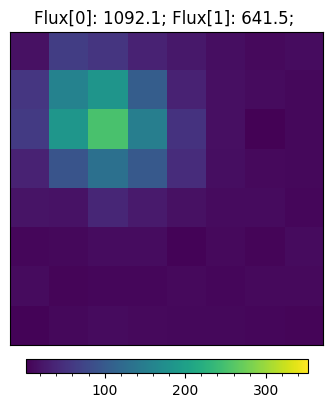

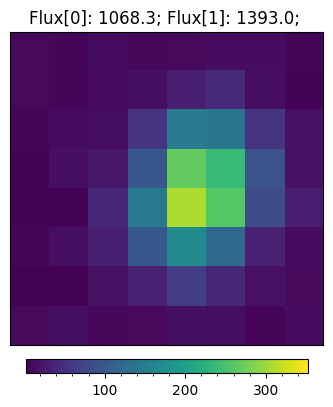

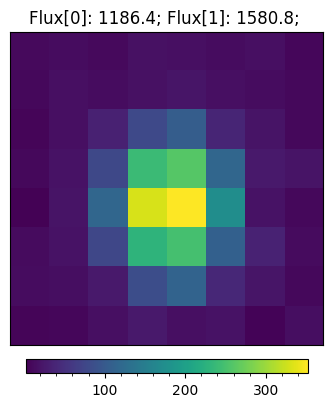

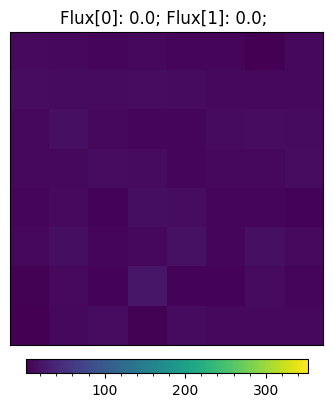

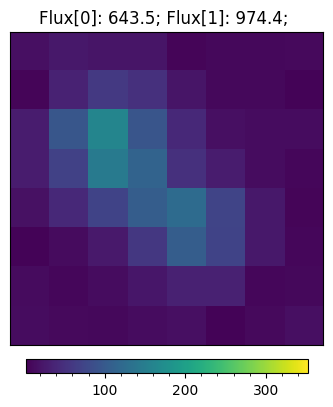

In [7]:
sim_out = image_simulator.generate(5, seed=7272)
img_min = sim_out["images"].min()
img_max = sim_out["images"].max()
for sub_img, flux in zip(sim_out["images"], sim_out["fluxes"]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    im = ax.imshow(sub_img.cpu(), vmin=img_min, vmax=img_max)
    ax.set_xticks([])
    ax.set_yticks([])
    if flux.shape[0] == 1:
        ax.set_title(f"Flux: {flux.item():.1f}")
    else:
        t = ""
        for i, f in enumerate(flux):
            t += f"Flux[{i}]: {f.item():.1f}; "
        ax.set_title(t)
    cb = fig.colorbar(im, ax=ax, 
                      location="bottom", shrink=0.6,
                      anchor=(0.5, 2.0))
    cb.minorticks_on()
    fig.tight_layout()
    fig.show()

In [63]:
training_diffusion = RMLDiffusion(num_timesteps=training_time_steps,
                                  num_sampling_steps=ddim_steps,
                                  m=64,
                                  lambda_=1.0,
                                  beta=0.5)
sampling_diffusion = training_diffusion
# schedule_sampler = create_named_schedule_sampler("uniform", training_diffusion)
# schedule_sampler = SpeedSampler(diffusion=training_diffusion,
#                                 lam=0.6,
#                                 k=5,
#                                 tau=700)
schedule_sampler = SigmoidSampler(training_diffusion, 0)

In [9]:
my_net = FourierMLP(data_shape=[8,], 
                    num_layers=8, 
                    hidden_ch=256).to(device=device)
my_optimizer = torch.optim.Adam(my_net.parameters(), lr=1e-3, amsgrad=True)
my_scheduler = torch.optim.lr_scheduler.MultiStepLR(my_optimizer, milestones=[training_iters // 4 * 3], gamma=0.1)

In [10]:
max_flux_boundary = 2000.0
def encode_flux(flux: torch.Tensor):
    assert flux.min() >= 0.0
    flux = flux.clamp(max=max_flux_boundary)
    return (torch.log1p(flux) / torch.log1p(torch.tensor(max_flux_boundary))) * 2 - 1

def decode_flux(flux_minus1_to_1: torch.Tensor):
    assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
    return torch.expm1((flux_minus1_to_1 + 1) / 2 * torch.log1p(torch.tensor(max_flux_boundary)))

In [11]:
# max_flux_boundary = 2000.0
# def encode_flux(flux: torch.Tensor):
#     assert flux.min() >= 0.0
#     flux = flux.clamp(max=max_flux_boundary)
#     return (flux / max_flux_boundary) * 2 - 1

# def decode_flux(flux_minus1_to_1: torch.Tensor):
#     assert flux_minus1_to_1.min() >= -1.0 and flux_minus1_to_1.max() <= 1.0
#     return (flux_minus1_to_1 + 1) / 2 * max_flux_boundary

In [12]:
def encode_x_start(catalog):
    n_sources = catalog["counts"]  # (b, )
    locs = catalog["locs"]  # (b, m, 2)
    fluxes = catalog["fluxes"].unsqueeze(-1)  # (b, m, 1)
    n_sources = (n_sources.unsqueeze(-1) >= torch.arange(1, locs.shape[1] + 1, device=locs.device)).unsqueeze(-1)  # (b, m, 1)
    x_start = torch.cat([n_sources * 2 - 1, locs / image_size * 2 - 1, encode_flux(fluxes)], dim=-1)  # (b, m, 4)
    sorted_index = x_start[..., -1].argsort(dim=-1, descending=True)  # (b, m)
    return torch.take_along_dim(x_start, repeat(sorted_index, "... -> ... r", r=4), dim=-2)  # (b, m, 4)

In [33]:
def decode_x_start(output_x_start):
    n_sources = output_x_start[..., 0] > 0.0  # (b, m)
    locs = (output_x_start[..., 1:3] + 1) / 2 * image_size  # (b, m, 2)
    fluxes = decode_flux(output_x_start[..., 3])  # (b, m)
    return {
        "counts": n_sources.sum(dim=-1),
        "n_sources": n_sources.int(),
        "locs": locs,
        "fluxes": fluxes,
    }

In [14]:
def normalize_image(input_image):
    match image_normalize_strategy:
        case "none":
            output_image = input_image
        case "log":
            output_image = torch.log1p(input_image)
        case "linear_scale":
            output_image = input_image / 1000
        case _:
            raise NotImplementedError()
    return output_image

In [15]:
my_net.train()
loss_record = []
for i in tqdm.tqdm(list(range(training_iters))):
    catalog = image_simulator.generate(batch_size)
    t, batch_sample_weights, batch_loss_weights = schedule_sampler.sample(batch_size, device=device)
    input_image = catalog["images"]  # (b, h, w)
    input_image = normalize_image(input_image)
    train_loss_args = {
        "model": my_net,
        "x_start": encode_x_start(catalog),
        "t": t,
        "loss_weights": batch_loss_weights
    }
    loss = training_diffusion.training_losses(**train_loss_args, 
                                              model_kwargs={"image": input_image})["loss"]
    loss = (loss * batch_sample_weights).mean()
    loss_record.append(loss.item())
    my_optimizer.zero_grad()
    loss.backward()
    my_optimizer.step()
    my_scheduler.step()
    if (i + 1) % log_freq == 0:
        print(f"[{i + 1}/{training_iters}] loss: {loss.item():.3e}")

  5%|▌         | 502/10000 [00:29<09:34, 16.54it/s]

[500/10000] loss: 1.564e-01


 10%|█         | 1002/10000 [01:03<10:32, 14.22it/s]

[1000/10000] loss: 1.089e-01


 15%|█▌        | 1502/10000 [01:39<10:09, 13.95it/s]

[1500/10000] loss: 9.224e-02


 20%|██        | 2002/10000 [02:16<09:46, 13.64it/s]

[2000/10000] loss: 9.245e-02


 25%|██▌       | 2502/10000 [02:54<09:25, 13.25it/s]

[2500/10000] loss: 7.116e-02


 30%|███       | 3002/10000 [03:32<08:57, 13.02it/s]

[3000/10000] loss: 7.778e-02


 35%|███▌      | 3502/10000 [04:10<08:08, 13.29it/s]

[3500/10000] loss: 6.429e-02


 40%|████      | 4002/10000 [04:49<07:39, 13.06it/s]

[4000/10000] loss: 6.403e-02


 45%|████▌     | 4502/10000 [05:27<07:01, 13.04it/s]

[4500/10000] loss: 5.716e-02


 50%|█████     | 5002/10000 [06:06<06:22, 13.06it/s]

[5000/10000] loss: 6.177e-02


 55%|█████▌    | 5502/10000 [06:45<05:46, 12.97it/s]

[5500/10000] loss: 5.683e-02


 60%|██████    | 6002/10000 [07:24<05:07, 13.01it/s]

[6000/10000] loss: 5.596e-02


 65%|██████▌   | 6502/10000 [08:02<04:25, 13.16it/s]

[6500/10000] loss: 5.278e-02


 70%|███████   | 7002/10000 [08:41<03:50, 12.99it/s]

[7000/10000] loss: 5.005e-02


 75%|███████▌  | 7502/10000 [09:21<03:12, 12.97it/s]

[7500/10000] loss: 5.207e-02


 80%|████████  | 8002/10000 [09:59<02:31, 13.21it/s]

[8000/10000] loss: 4.588e-02


 85%|████████▌ | 8502/10000 [10:38<01:55, 12.94it/s]

[8500/10000] loss: 4.606e-02


 90%|█████████ | 9002/10000 [11:18<01:17, 12.87it/s]

[9000/10000] loss: 4.118e-02


 95%|█████████▌| 9502/10000 [11:57<00:38, 13.01it/s]

[9500/10000] loss: 4.693e-02


100%|██████████| 10000/10000 [12:36<00:00, 13.21it/s]


[10000/10000] loss: 4.462e-02


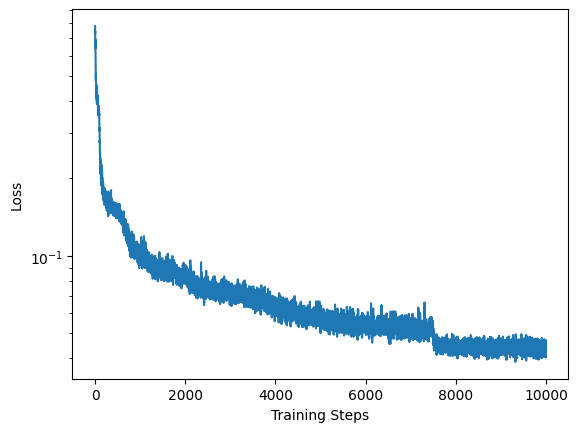

In [16]:
plt.plot(loss_record)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.yscale("log")
plt.show()

In [17]:
my_net.eval()
val_true_cat = []
val_est_cat = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(100))):
        val_catalog = image_simulator.generate(batch_size=1024, 
                                               seed=seed)
        val_true_cat.append(move_data_to_device(val_catalog, "cpu"))
        input_image = normalize_image(val_catalog["images"])
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1024, max_objects, 4),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        sample = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, eta=ddim_eta)
        val_est_cat.append(move_data_to_device(decode_x_start(sample), "cpu"))

100%|██████████| 100/100 [00:02<00:00, 42.86it/s]


In [19]:
diffusion_pred_ns = torch.cat([c["counts"] for c in val_est_cat], dim=0)
diffusion_true_ns = torch.cat([c["counts"] for c in val_true_cat], dim=0)

In [20]:
diffusion_true_ns.shape, diffusion_pred_ns.shape

(torch.Size([102400]), torch.Size([102400]))

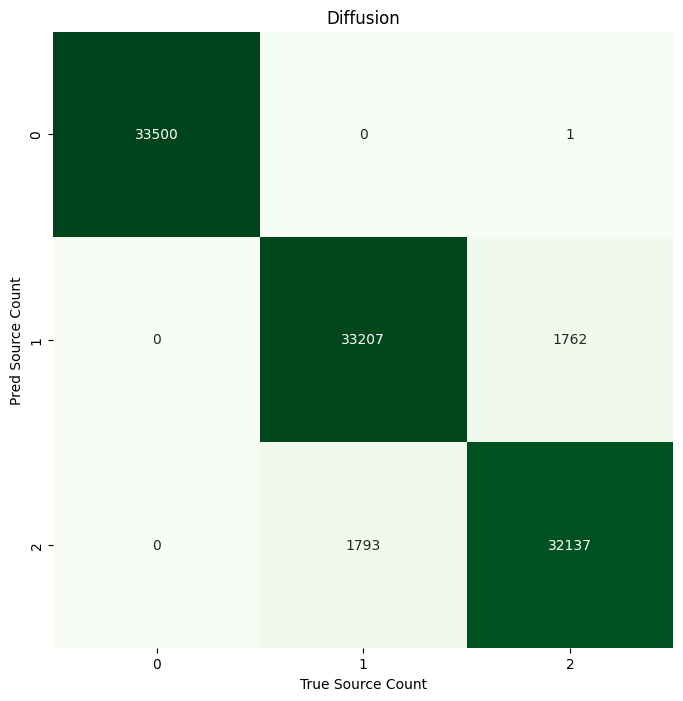

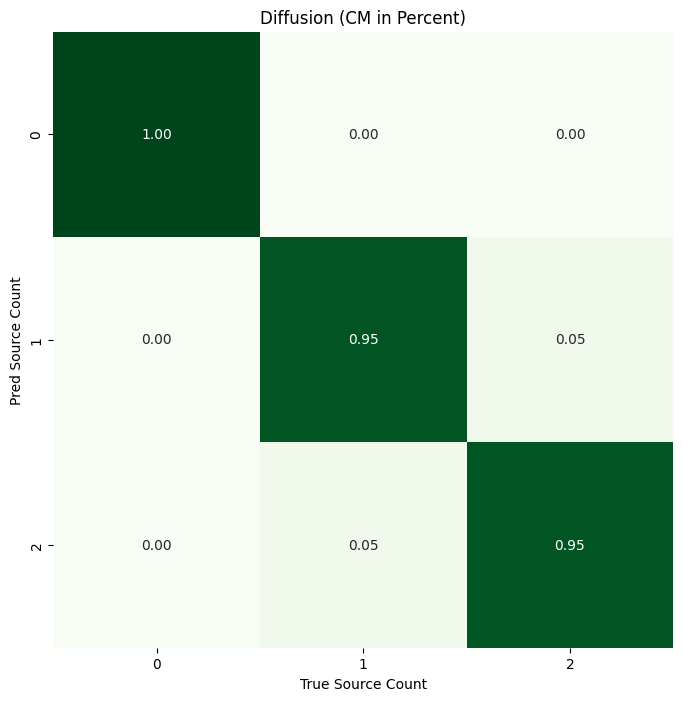

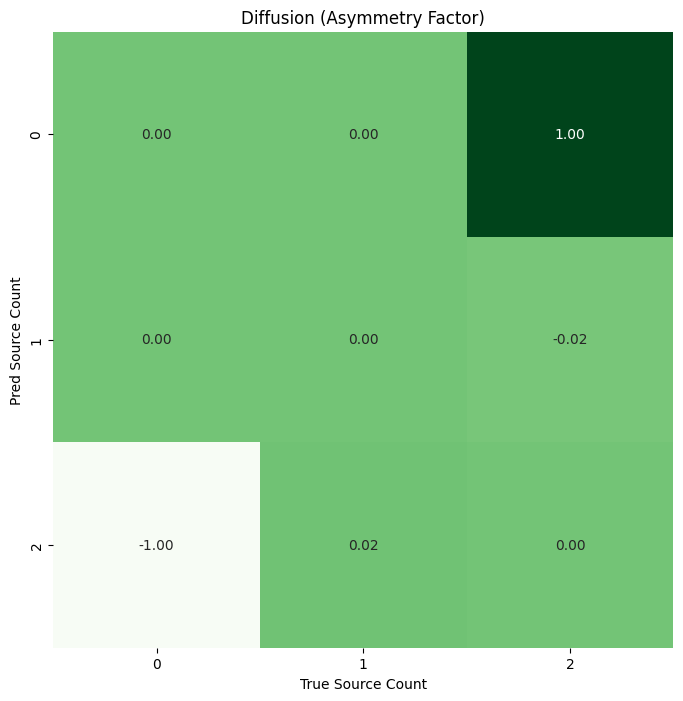

In [21]:
d_cm = torch.zeros(3, 3, dtype=torch.int)
for ri in range(d_cm.shape[0]):
    for ci in range(d_cm.shape[1]):
        d_cm[ri, ci] = ((diffusion_pred_ns == ri) & (diffusion_true_ns == ci)).sum()

bin_labels = [i for i in range(3)]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(d_cm,
            annot=True,
            fmt="d", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=ax)
ax.set_xlabel("True Source Count")
ax.set_ylabel("Pred Source Count")
ax.set_title("Diffusion")
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap(d_cm / torch.sum(d_cm, dim=0, keepdim=True),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=ax)
ax.set_xlabel("True Source Count")
ax.set_ylabel("Pred Source Count")
ax.set_title("Diffusion (CM in Percent)")
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sns.heatmap((d_cm - d_cm.T) / torch.minimum(d_cm, d_cm.T).clamp(min=1),
            annot=True,
            fmt=".2f", cmap="Greens", cbar=False,
            xticklabels=bin_labels,
            yticklabels=bin_labels,
            ax=ax)
ax.set_xlabel("True Source Count")
ax.set_ylabel("Pred Source Count")
ax.set_title("Diffusion (Asymmetry Factor)")
fig.show()

In [99]:
my_cat = {
    "counts": torch.ones(1, device=device, dtype=torch.int) * 2,
    "locs": torch.tensor([[3.0, 3.0], [5.0, 5.0]], device=device).unsqueeze(0),
    "fluxes": torch.tensor([1000.0, 1000.0], device=device).unsqueeze(0)
}

In [100]:
my_cat = image_simulator._generate_by_catalog(my_cat)

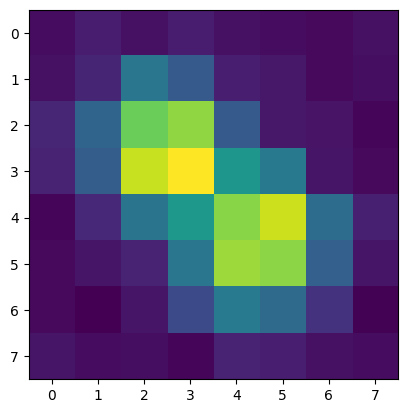

In [101]:
plt.imshow(my_cat["images"][0].cpu())
plt.show()

In [102]:
input_image = normalize_image(my_cat["images"])
traces = []
with torch.inference_mode():
    for i in tqdm.tqdm(list(range(100))):
        diffusion_sampling_config = {
            "model": my_net,
            "shape": (1, max_objects, 4),
            "clip_denoised": True,
            "model_kwargs": {"image": input_image}
        }
        _sample, inter = sampling_diffusion.ddim_sample_loop(**diffusion_sampling_config, 
                                                             eta=ddim_eta, 
                                                             return_intermediate=True)
        traces.append([decode_x_start(i) for i in inter])

100%|██████████| 100/100 [00:03<00:00, 25.01it/s]


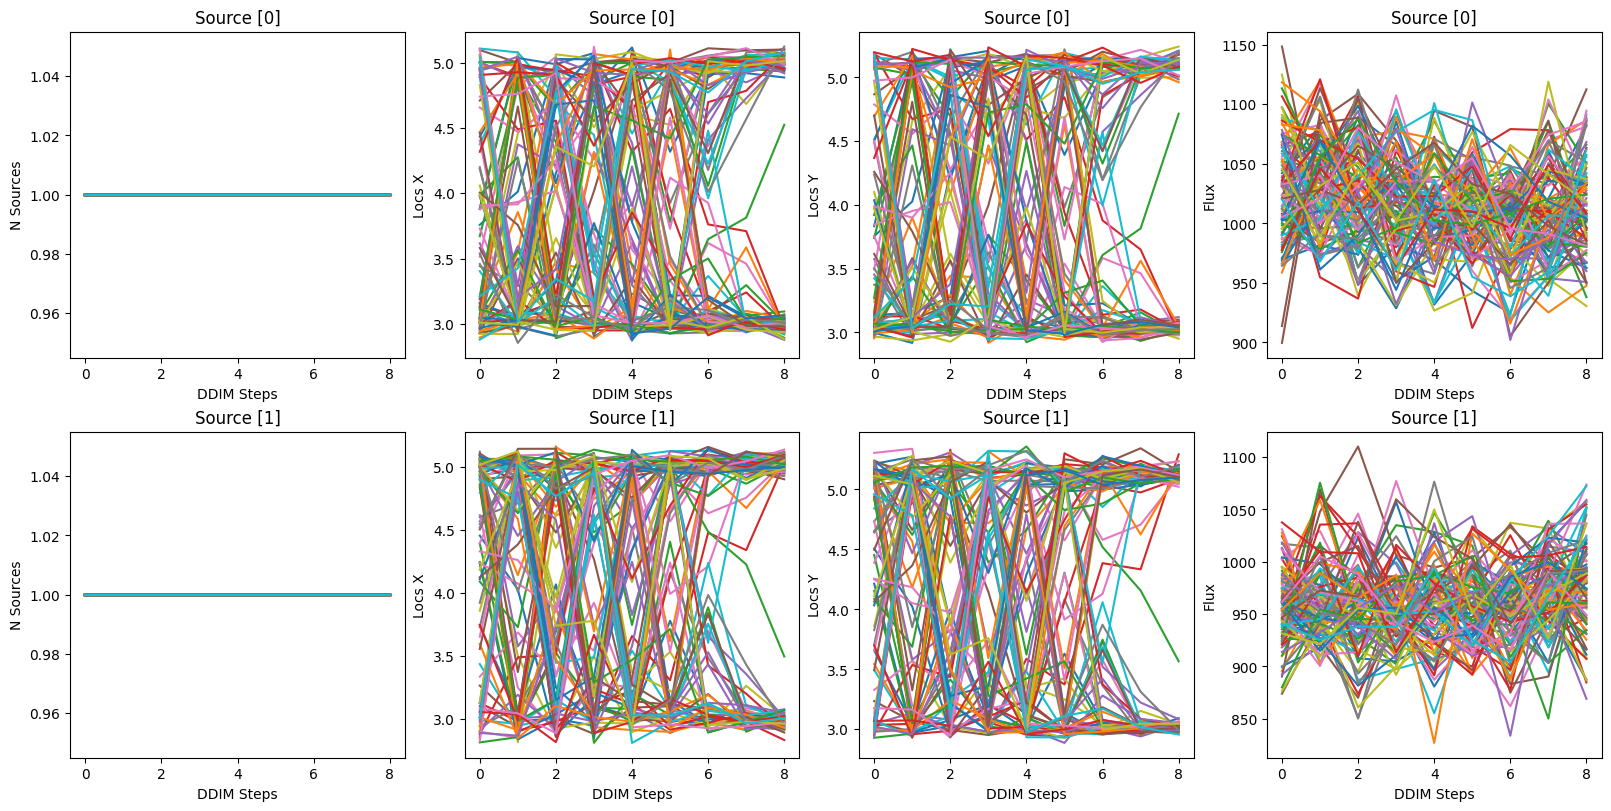

In [103]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
for t in traces:
    x = list(range(len(t)))
    for mi in range(2):
        axes[mi, 0].plot(x, [tt["n_sources"][0, mi].item() for tt in t])
        axes[mi, 0].set_ylabel("N Sources")
        axes[mi, 0].set_xlabel("DDIM Steps")
        axes[mi, 0].set_title(f"Source [{mi}]")
        axes[mi, 1].plot(x, [tt["locs"][0, mi, 1].item() for tt in t])
        axes[mi, 1].set_ylabel("Locs X")
        axes[mi, 1].set_xlabel("DDIM Steps")
        axes[mi, 1].set_title(f"Source [{mi}]")
        axes[mi, 2].plot(x, [tt["locs"][0, mi, 0].item() for tt in t])
        axes[mi, 2].set_ylabel("Locs Y")
        axes[mi, 2].set_xlabel("DDIM Steps")
        axes[mi, 2].set_title(f"Source [{mi}]")
        axes[mi, 3].plot(x, [tt["fluxes"][0, mi].item() for tt in t])
        axes[mi, 3].set_ylabel("Flux")
        axes[mi, 3].set_xlabel("DDIM Steps")
        axes[mi, 3].set_title(f"Source [{mi}]")
fig.show()    